Ver si existe relacion entre nivel de satisfaccion  en el trabajo y la rotacion de los empleados y ver la magnitud de la relacion  

H0 "Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa. Se sospecha que los empleados con niveles de satisfacción más bajos tienen una mayor probabilidad de dejar la empresa".  

Para ello deberéis crear una columna nueva en base al nivel de satisfacción en el trabajo para crear dos grupos, las condiciones para crear los grupos son:

    - Grupo A (Control): Empleados con un nivel de satisfacción en el trabajo igual o superior a 3 en una escala de 1 a 5

    - Grupo B (Variante): Empleados con un nivel de satisfacción en el trabajo inferior a 3 en la misma escala.  
    
La métrica principal que debes usar es la tasa de rotación de empleados (Attrition) en cada grupo. Recordemos que, en esta columna, "No" indica que el empleado no ha dejado la empresa (sin rotación), mientras que "Yes" indica que el empleado ha dejado la empresa (con rotación).


- Analiza los resultados.

- Calcula la magnitud de esta relación utilizando estadísticas como la diferencia de medias por ejemplo.  




In [1]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar los distintos test
# ------------------------------------------------------------------------------

from scipy.stats import ttest_ind, norm, chi2_contingency, f_oneway
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy import stats
from scipy.stats import levene
from scipy.stats import shapiro, poisson, chisquare, expon, kstest

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore") 

In [2]:
df = pd.read_csv("Files/df_fase1.csv", index_col=0)
df.head(2)

,IdEmployee,EmployeeNumber,Age,DateBirth,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,RemoteWork
0,0,"162,0",52,1972,No,no-data,684.0,6,3,no-data,1,Male,51.0,3,5,Research Director,3,no-data,6462.0,7,No,13,3,3,0,no-data,5,3,20,15,15,True
1,1,"259,0",53,1971,No,no-data,699.0,1,4,Life Sciences,1,Male,65.0,2,5,Manager,3,no-data,5678.0,0,no-data,14,3,1,1,"34,0",5,3,33,11,9,True


- Divide a los empleados en los grupos A y B según los criterios establecidos.

In [3]:
# División del grupo A, empleados con un nivel de satisfacción igual o superior a 3.
# Vamos a imputar una columna, que nos indique, por fila, a qué grupo pertenece según su JobSatisfaction.

df['GroupSatisfaction'] = df['JobSatisfaction'].apply(lambda x: 'A' if x >= 3 else 'B')

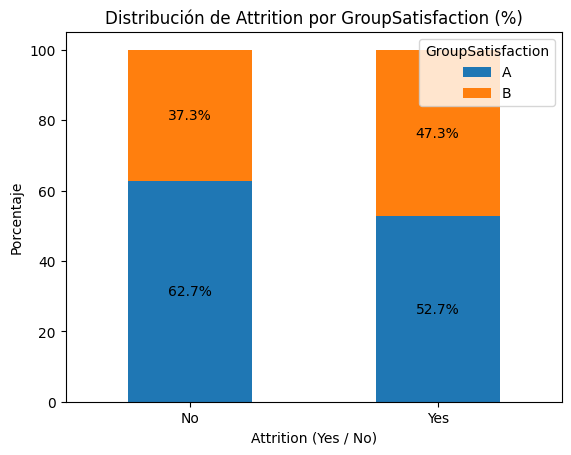

In [5]:

# Verificar que el DataFrame no sea None
if df is not None:
    # Verificar si las columnas necesarias existen
    if 'Attrition' in df.columns and 'GroupSatisfaction' in df.columns:
        
        # Paso 1: Agrupamos los datos por "Attrition" y "GroupSatisfaction"
        conteo_grupos = df.groupby(['Attrition', 'GroupSatisfaction']).size().unstack()

        # Paso 2: Calculamos los porcentajes para cada grupo (evitar errores si hay NaN)
        porcentajes = conteo_grupos.apply(lambda x: x / x.sum() * 100, axis=1)

        # Paso 3: Crear el gráfico de barras
        ax = porcentajes.plot(kind='bar', stacked=True)

        # Añadir títulos y etiquetas
        plt.title('Distribución de Attrition por GroupSatisfaction (%)')
        plt.ylabel('Porcentaje')
        plt.xlabel('Attrition (Yes / No)')
        plt.legend(title='GroupSatisfaction')
        plt.xticks(rotation=0)

        # Paso 4: Añadir los porcentajes sobre las barras
        for p in ax.patches:
            # Obtener las coordenadas del centro de la barra y el porcentaje
            width = p.get_width()
            height = p.get_height()
            x = p.get_x() + width / 2
            y = p.get_y() + height / 2
            
            # Solo anotamos si el valor es mayor que cero
            if height > 0:
                ax.annotate(f'{height:.1f}%', (x, y), ha='center', va='center')

        # Mostrar el gráfico
        plt.show()
    else:
        print("Las columnas 'Attrition' y/o 'GroupSatisfaction' no están en el DataFrame.")
else:
    print("El DataFrame es None o no se ha cargado correctamente.")


In [5]:
df.sample(3)

,IdEmployee,EmployeeNumber,Age,DateBirth,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,RemoteWork,GroupSatisfaction
800,800,"1597,0",35,1989,No,travel_frequently,653.0,36,4,no-data,3,Male,92.0,2,2,Healthcare Representative,3,no-data,15332.0,1,No,14,3,2,1,"8,0",3,2,8,7,7,False,A
637,637,"379,0",22,2002,No,travel_rarely,996.0,3,2,no-data,1,Male,100.0,2,1,Research Scientist,3,Single,10531.0,1,No,17,3,1,0,no-data,4,4,3,1,0,False,A
453,453,"1397,0",40,1984,No,non-travel,1485.0,25,2,no-data,1,Male,71.0,3,3,Healthcare Representative,3,no-data,3449.0,3,No,21,4,2,1,"13,0",2,3,6,0,5,False,A


- Calcula la tasa de rotación (porcentaje de empleados que dejaron la empresa) en cada grupo.

In [20]:
# rotacion = Los que han dejado la empresa / el total de los empleados registrados

# Attrition --> los que tienen un YES. Estos son los que HAN DEJADO LA EMPRESA. 

rotationA = (len(df[(df['Attrition'] == 'Yes') & (df['GroupSatisfaction'] == 'A')])) / len(df['Attrition'] == 'Yes') * 100
rotationA

8.461025982678215

In [7]:
print(len(df[(df['GroupSatisfaction'] == 'A')]))
print(rotationA)

917
8.461025982678215


Del total de 927 que tienen una satisfacción de 3 o más, el 8.461 % NO están en la empresa ya.

In [21]:
rotationB = (len(df[(df['Attrition'] == 'Yes') & (df['GroupSatisfaction'] == 'B')])) / len(df['Attrition'] == 'Yes') * 100
rotationB

7.59493670886076

Vemos también vamos a ver la tasa de satisfaccion de los que no han dejado la empresa

In [16]:
 (len(df[(df['Attrition'] == 'No') & (df['GroupSatisfaction'] == 'B')])) / len(df['GroupSatisfaction'] == 'B') * 100

31.312458361092606

In [17]:
 (len(df[(df['Attrition'] == 'No') & (df['GroupSatisfaction'] == 'A')])) / len(df['GroupSatisfaction'] == 'A') * 100

52.63157894736842

Del total de 584 que tienen una satisfacción de menos de 3 puntos, el 7.5949 % ya no están en la empresa.

Vamos a mostrar en un gráfico los dos grupos y cómo se distribuyen:

In [10]:
# Debemos meterlos en un DataFrame primeramente para poderlos representar:

rotation_data = pd.DataFrame({
    'Group':['A', 'B'],
    'Rotation Rate':[rotationA, rotationB]
})

- Realiza un análisis estadístico para determinar si hay una diferencia significativa en la tasa de rotación entre los grupos A y B.

In [18]:
# Generamos cada grupo:

groupA = df[df['GroupSatisfaction'] == 'A']
groupA.sample(2)

,IdEmployee,EmployeeNumber,Age,DateBirth,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,RemoteWork,GroupSatisfaction
532,532,"1179,0",31,1993,No,travel_rarely,852.0,10,3,Marketing,1,Male,72.0,2,2,Sales Executive,3,Married,2706.0,1,No,18,3,1,1,no-data,3,3,10,1,4,False,A
631,631,"338,0",34,1990,No,travel_rarely,832.0,5,4,Life Sciences,1,Female,63.0,2,1,Research Scientist,4,Married,14776.0,1,no-data,13,3,3,1,"2,0",2,2,2,0,2,True,A


In [19]:
#### FALTA PONER EL GRAFIQUITO ESTE ASQUEROSO QUE NO ME SALE :(
### PARA VER EN COLORINCHOS CUÁNTO COGE DE ROTACION EN CADA GRUPO

sns.barplot(x=rotationA, data=groupA, index=[0])

plt.xlabel('Groups')
plt.ylabel('Rotation Rate %')
plt.title('Tasa de Rotación por Grupos')

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

ValueError: If using all scalar values, you must pass an index

In [14]:
groupB = df[df['GroupSatisfaction'] == 'B']
groupB.sample(2)

,IdEmployee,EmployeeNumber,Age,DateBirth,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,RemoteWork,GroupSatisfaction
1488,1384,no-data,33,1991,No,no-data,234.0,36,4,no-data,1,Male,68.0,2,1,Sales Representative,2,no-data,18024.0,0,no-data,14,3,2,1,no-data,2,3,2,2,2,True,B
1210,1106,no-data,42,1982,No,no-data,334.0,10,4,no-data,1,Male,88.0,3,4,Manager,2,no-data,15896.0,1,no-data,19,3,2,0,no-data,2,3,22,0,4,True,B


In [15]:
groupB.corr( method = "spearman")


ValueError: could not convert string to float: '81,0'

In [ ]:
# Primero comprobamos si cada conjunto de datos sigue una distribución normal:



#### Prueba de Shapiro-Wilk

La prueba de Shapiro-Wilk es una prueba estadística paramétrica que se utiliza para evaluar la normalidad de una muestra. La hipótesis nula (H0) de esta prueba es que la muestra proviene de una población con distribución normal.

Hipótesis nula (H0): Los datos se distribuyen normalmente.
Hipótesis alternativa (H1): Los datos no se distribuyen normalmente.

##### Interpretación de los resultados
p-value > alpha: No hay suficiente evidencia para rechazar la hipótesis nula. Se concluye que los datos se ajustan a una distribución normal.
p-value <= alpha: Se rechaza la hipótesis nula. Los datos no se ajustan a una distribución normal.

In [79]:
# Primero comprobamos qué tipo de distribución tenemos con la prueba de Shapiro:

p_value = shapiro(df['IdEmployee']).pvalue

alpha = 0.05

if p_value > alpha:
    print("Los datos se ajustan a una distribución normal (p-value =", p_value, ")")
else:
    print("Los datos no se ajustan a una distribución normal (p-value =", p_value, ")")

Los datos no se ajustan a una distribución normal (p-value = 3.997729973138971e-21 )


In [ ]:
# Haremos la prueba Z porque conocemos la desviación estándar de la población y es apropiada para muestras grandes:



In [ ]:
mport pandas as pd
import matplotlib.pyplot as plt


# Crear el gráfico de barras
fig, ax = plt.subplots()

# Crear un gráfico apilado de barras con los datos
df.pivot(index='Categoria', columns='Estado', values='Porcentaje').plot(kind='bar', stacked=True, ax=ax)

# Añadir títulos y etiquetas
ax.set_title('Porcentaje de Trabajadores Satisfechos y Menos Satisfechos')
ax.set_ylabel('Porcentaje')
ax.set_xlabel('Categoria')

# Mostrar la leyenda y el gráfico
plt.legend(title='Estado')
plt.tight_layout()
plt.show
() 